# Projekt predykcyjny: Prognozowanie ceny złota (XAUPLN)

**Autor:** Jan Zdaniewicz

## Cel projektu

Celem niniejszego projektu jest opracowanie i przetestowanie modelu predykcyjnego służącego do prognozowania przyszłych wartości dziennego kursu złota wyrażonego w polskich złotych (symbol: **XAUPLN**). Model opiera się na danych historycznych i ma za zadanie estymować wartość zamknięcia (`Close`) kursu złota na podstawie wybranych zmiennych objaśniających.

## Zakres analizy

W analizie wykorzystano historyczne dane dzienne dla następujących instrumentów finansowych:

- **XAUPLN** – Złoto (ozt) / PLN – zmienna zależna (target)
- **XAGPLN** – Srebro (ozt) / PLN
- **XPTPLN** – Platyna (ozt) / PLN
- **BTCPLN** – Bitcoin / PLN
- **USDPLN** – Dolar amerykański / PLN

Wyżej wymienione instrumenty zostały dobrane ze względu na ich możliwy wpływ na cenę złota, zarówno z perspektywy rynków surowcowych, jak i walutowych oraz inwestycyjnych.

## Zakres czasowy danych

Dane wykorzystane w projekcie obejmują okres od **19 lipca 2010 roku** do **12 czerwca 2025 roku**. Początek tego zakresu został określony na podstawie dostępności danych dla instrumentu **BTCPLN** – najwcześniejsze notowania Bitcoina w relacji do polskiego złotego w serwisie [Stooq.pl](https://stooq.pl) zaczynają się właśnie od **19.07.2010**. W celu zapewnienia spójności czasowej, wszystkie pozostałe dane zostały przycięte do tego samego punktu początkowego.

## Cel modelowania

Celem modelowania jest:

- przygotowanie wspólnego zestawu danych na podstawie danych historycznych z plików CSV,
- analiza zależności pomiędzy zmiennymi (np. korelacje),
- zbudowanie modelu predykcyjnego (regresyjnego),
- dokonanie oceny skuteczności modelu przy różnych ustawieniach i architekturach,
- wyciągnięcie wniosków na temat wpływu poszczególnych zmiennych na cenę złota.

Projekt realizowany jest w środowisku **Jupyter Notebook**, a wszystkie analizy zostaną przeprowadzone z wykorzystaniem języka **Python**.


Import bibliotek

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


Wczytywanie danych i filtrowanie interesujących nas danych 

In [9]:
# Ścieżka do folderu z danymi
data_path = Path.cwd().parent / 'Data'

# Sprawdź katalog roboczy i zawartość folderu Data
print("Aktualny katalog roboczy:", Path.cwd())
print("Pełna ścieżka do folderu Data:", data_path)
print("Pliki w folderze Data:", os.listdir(data_path))

# Lista plików i odpowiadające im etykiety
files = {
    'xaupln_d.csv': 'XAUPLN',
    'xagpln_d.csv': 'XAGPLN',
    'xptpln_d.csv': 'XPTPLN',
    'btcpln_d.csv': 'BTCPLN',
    'usdpln_d.csv': 'USDPLN'
}

# Lista DataFrame'ów
data_frames = []

# Zakres dat do filtrowania
start_date = pd.to_datetime("2010-07-19")
end_date = pd.to_datetime("2025-06-12")

# Wczytaj i przygotuj dane
data_frames = []

for filename, label in files.items():
    file_path = data_path / filename
    df = pd.read_csv(file_path, parse_dates=['Data'])
    df = df[['Data', 'Zamkniecie']]
    df = df[(df['Data'] >= start_date) & (df['Data'] <= end_date)]
    df.rename(columns={'Zamkniecie': label}, inplace=True)
    data_frames.append(df)

# Łączenie danych po dacie
merged_df = data_frames[0]
for df in data_frames[1:]:
    merged_df = pd.merge(merged_df, df, on='Data', how='inner')

# Ustawienie daty jako indeks
merged_df.set_index('Data', inplace=True)

# Podgląd danych
display(merged_df.head())

Aktualny katalog roboczy: c:\Users\xbots\OneDrive\Pulpit\Projekt machine\Project gold\Notebooks
Pełna ścieżka do folderu Data: c:\Users\xbots\OneDrive\Pulpit\Projekt machine\Project gold\Data
Pliki w folderze Data: ['btcpln_d.csv', 'usdpln_d.csv', 'xagpln_d.csv', 'xaupln_d.csv', 'xptpln_d.csv']


,XAUPLN,XAGPLN,XPTPLN,BTCPLN,USDPLN
Data,,,,,
2010-07-19,3762.7,56.171,4803.9,0.25736,3.1852
2010-07-20,3793.4,56.286,4808.8,0.23821,3.1872
2010-07-21,3812.5,56.848,4868.4,0.25340,3.1991
2010-07-22,3790.2,57.489,4822.2,0.16000,3.1683
2010-07-23,3755.5,57.283,4852.1,0.19802,3.1622


Najsilniejsza korelacja:
XAUPLN ↔ BTCPLN = 0.89

Najsłabsza korelacja:
XPTPLN ↔ USDPLN = -0.49


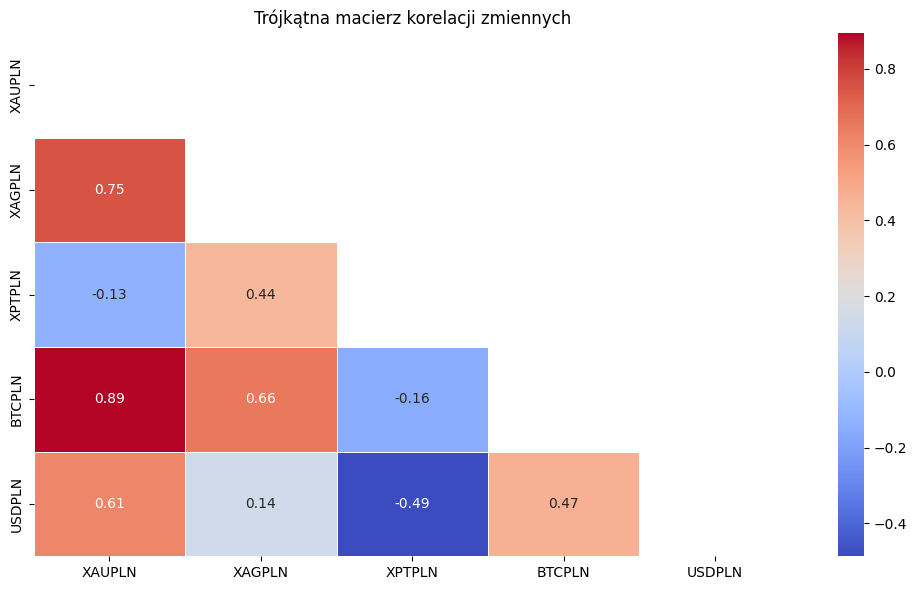

In [10]:
# Oblicz macierz korelacji
corr = merged_df.corr()

# Funkcja do znalezienia najmocniejszej i najsłabszej korelacji (poza przekątną)
def find_extreme_correlations(corr_matrix):
    # Skopiuj i zamień przekątną na NaN, aby jej nie uwzględniać
    corr_copy = corr_matrix.copy()
    np.fill_diagonal(corr_copy.values, np.nan)

    # Znajdź maksymalną i minimalną korelację
    max_corr = corr_copy.max().max()
    min_corr = corr_copy.min().min()

    # Znajdź odpowiadające pary zmiennych
    max_pair = corr_copy.stack().idxmax()
    min_pair = corr_copy.stack().idxmin()

    print("Najsilniejsza korelacja:")
    print(f"{max_pair[0]} ↔ {max_pair[1]} = {max_corr:.2f}\n")

    print("Najsłabsza korelacja:")
    print(f"{min_pair[0]} ↔ {min_pair[1]} = {min_corr:.2f}")

# Wywołaj analizę
find_extreme_correlations(corr)

# Utwórz maskę dla górnego trójkąta macierzy
mask = np.triu(np.ones_like(corr, dtype=bool))

# Rysuj trójkątną heatmapę
plt.figure(figsize=(10, 6))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Trójkątna macierz korelacji zmiennych')
plt.tight_layout()
plt.show()


## Analiza korelacji

W celu zbadania zależności pomiędzy zmienną docelową (**XAUPLN** – cena złota w PLN) a pozostałymi zmiennymi objaśniającymi, wyznaczono macierz korelacji. Na jej podstawie można zidentyfikować zarówno najsilniejsze, jak i najsłabsze powiązania liniowe.

### Najsilniejsza korelacja

Najsilniejszą dodatnią korelację z ceną złota (XAUPLN) wykazuje kurs **BTCPLN** (Bitcoin w PLN), dla którego współczynnik korelacji wynosi **0.89**. Oznacza to, że w analizowanym okresie zmiany kursu Bitcoina były silnie skorelowane ze zmianami ceny złota, co może wynikać z podobnej roli tych aktywów jako "alternatywnych" form lokowania kapitału.

### Najsłabsza korelacja

Najsłabszą (i lekko ujemną) korelację z ceną złota odnotowano dla kursu **XPTPLN** (platyna w PLN), gdzie współczynnik korelacji wynosi **-0.13**. Sugeruje to brak wyraźnej zależności pomiędzy notowaniami złota a platyny w polskich złotych, przynajmniej w ujęciu liniowym.




Regresja liniowa – Wyniki na danych testowych (2025):
MAE:  1436.39
MSE:  2704551.46
RMSE: 1644.55
R2:   -8.2407


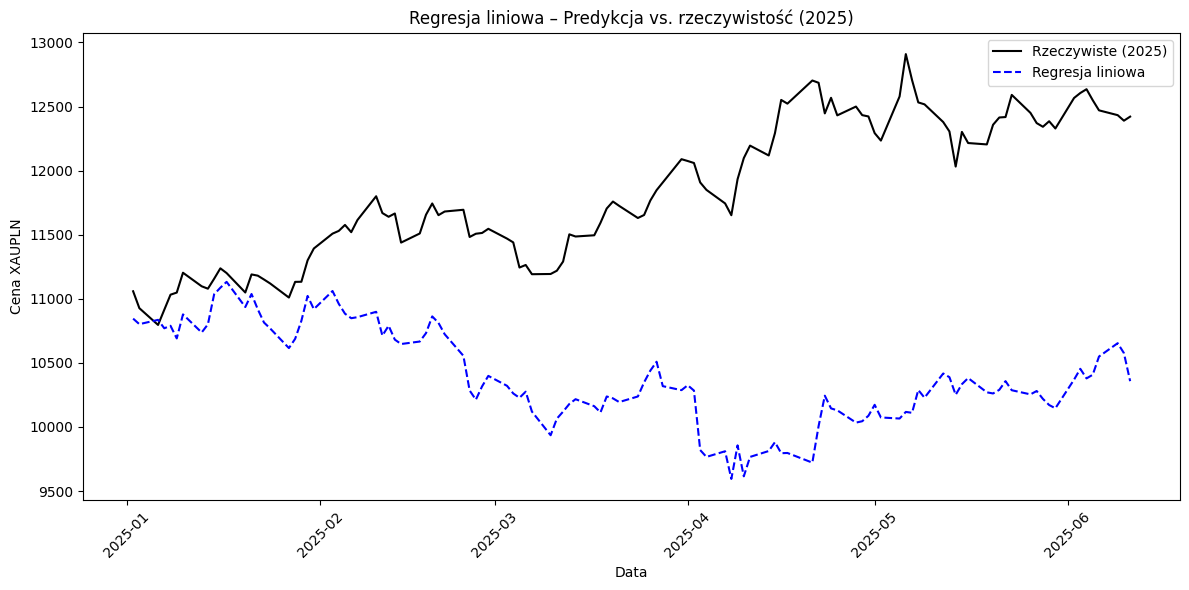

In [11]:
# 1. Przygotuj dane
features = ['XAGPLN', 'XPTPLN', 'BTCPLN', 'USDPLN']
target = 'XAUPLN'

# Zakres: uczymy się na danych do 2024, testujemy na 2025
train = merged_df.loc[:'2024-12-31']
test = merged_df.loc['2025-01-01':]

X_train = train[features].values
y_train = train[target].values
X_test = test[features].values
y_test = test[target].values

# 2. Model regresji liniowej
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# 3. Ewaluacja modelu
def print_metrics(y_true, y_pred, model_name):
    print(f"\n{model_name} – Wyniki na danych testowych (2025):")
    print(f"MAE:  {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"MSE:  {mean_squared_error(y_true, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"R2:   {r2_score(y_true, y_pred):.4f}")

print_metrics(y_test, y_pred_lr, "Regresja liniowa")

# 4. Wykres predykcji vs. rzeczywiste
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Rzeczywiste (2025)', color='black')
plt.plot(test.index, y_pred_lr, label='Regresja liniowa', linestyle='--', color='blue')
plt.legend()
plt.title('Regresja liniowa – Predykcja vs. rzeczywistość (2025)')
plt.xlabel('Data')
plt.ylabel('Cena XAUPLN')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Wyniki modelu: Regresja liniowa

Powyższy wykres przedstawia porównanie wartości rzeczywistych ceny złota w złotówkach (**XAUPLN**) w okresie od stycznia do czerwca 2025 roku z wartościami prognozowanymi przez model regresji liniowej.

Na wykresie:
- Czarna linia reprezentuje rzeczywiste notowania złota w 2025 roku.
- Niebieska linia przerywana przedstawia predykcję wygenerowaną przez regresję liniową, trenowaną na danych z lat 2010–2024.

### Wnioski

Model regresji liniowej wykazuje poprawną ogólną strukturę, ale **wyraźnie niedoszacowuje poziomu cen złota** w badanym okresie testowym. Chociaż zachowuje częściową zgodność z kierunkiem zmian, amplituda predykcji jest znacznie zaniżona względem rzeczywistości. Może to wskazywać na zbyt małą zdolność modelu liniowego do uchwycenia nieliniowych relacji pomiędzy zmiennymi objaśniającymi a zmienną docelową.


c:\Users\xbots\OneDrive\Pulpit\Projekt machine\Project gold\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 54302768.0000  
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 10706346.0000
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 4713001.0000
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 3380513.5000
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 2610117.7500
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 2307150.0000
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 1554944.0000
Epoch 8/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 1533243.7500
Epoch 9/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 1308081.0000
Epoch 10/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 1631308.6250
Epoch 11/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 1310027.0000
Epoch 12/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 1120785.7500
Epoch 13/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 1121418.2500
Epoch 14/50
117/117

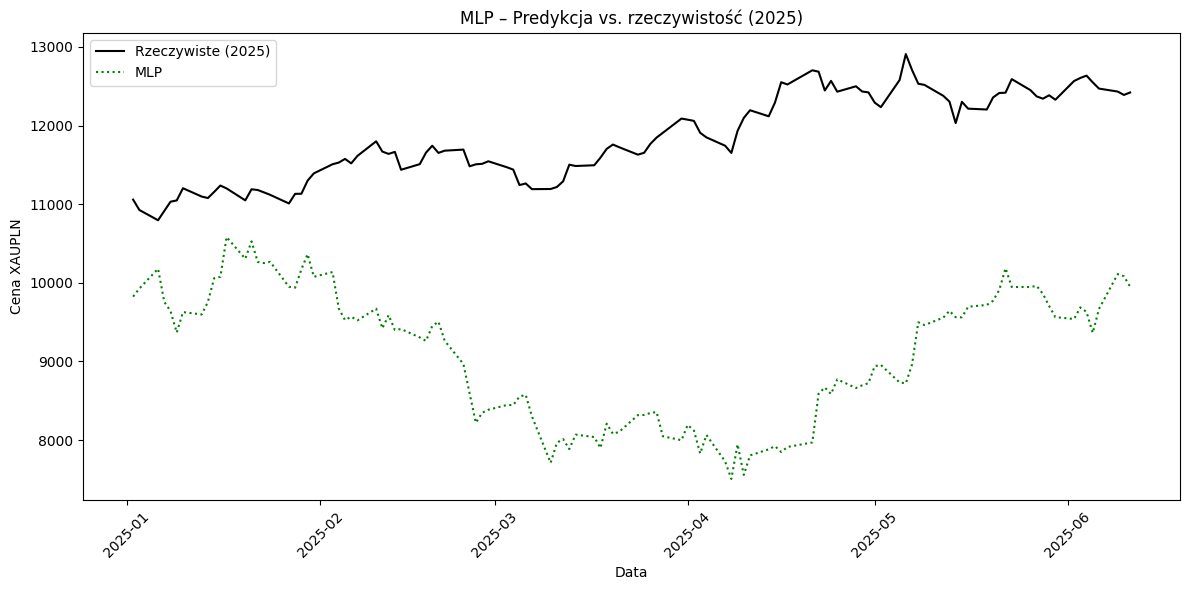

In [12]:
# 1. Dane takie same jak wcześniej
X_train = train[features].values
y_train = train[target].values
X_test = test[features].values
y_test = test[target].values

# 2. Budowa modelu MLP
mlp_model = Sequential()
mlp_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(32, activation='relu'))
mlp_model.add(Dense(1))

mlp_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
mlp_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# 3. Predykcja
y_pred_mlp = mlp_model.predict(X_test).flatten()

# 4. Ewaluacja
print_metrics(y_test, y_pred_mlp, "MLP (Sieć neuronowa)")

# 5. Wykres
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Rzeczywiste (2025)', color='black')
plt.plot(test.index, y_pred_mlp, label='MLP', linestyle=':', color='green')
plt.legend()
plt.title('MLP – Predykcja vs. rzeczywistość (2025)')
plt.xlabel('Data')
plt.ylabel('Cena XAUPLN')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Wyniki modelu: MLP (Sieć neuronowa)

Powyższy wykres przedstawia porównanie rzeczywistych notowań ceny złota w polskich złotych (**XAUPLN**) w pierwszej połowie 2025 roku z predykcjami wygenerowanymi przez model MLP (Multilayer Perceptron).

Na wykresie:
- Czarna linia reprezentuje rzeczywiste ceny złota w 2025 roku.
- Zielona linia kropkowana przedstawia prognozy wygenerowane przez sieć neuronową MLP wytrenowaną na danych historycznych z lat 2010–2024.

### Wnioski

Podobnie jak w przypadku regresji liniowej, model MLP zauważalnie **niedoszacowuje poziomu cen złota**. Niemniej jednak model ten lepiej odwzorowuje pewne lokalne trendy i wahania w serii czasowej w porównaniu do regresji. Nadal jednak występuje znaczna luka między wartościami rzeczywistymi a prognozowanymi, co sugeruje potrzebę dalszej optymalizacji architektury modelu i/lub zastosowania zaawansowanych technik przetwarzania danych.

---

## Funkcja pomocnicza: trenowanie i ocena modelu MLP

Poniższa funkcja `train_and_evaluate_mlp()` umożliwia elastyczne testowanie różnych architektur modelu MLP (Multilayer Perceptron). Pozwala na modyfikację:
- liczby neuronów w warstwach ukrytych,
- liczby warstw,
- funkcji aktywacji,
- wartości dropout,
- liczby epok i batch size.

Model trenowany jest na danych historycznych (2010–2024), a jego skuteczność oceniana jest na rzeczywistych danych z 2025 roku. Funkcja automatycznie wyświetla:
- metryki błędu: **MAE, MSE, RMSE, R²**
- wykres predykcji w porównaniu z rzeczywistością.

In [13]:
# Funkcja do budowy, treningu i oceny modelu MLP (sieci neuronowej)
def train_and_evaluate_mlp(X_train, y_train, X_test, y_test,
                           neurons=[64, 32], activation='relu',
                           dropout=0.2, epochs=50, batch_size=32,
                           model_name='MLP'):

    # Budowa modelu sekwencyjnego
    model = Sequential()

    # Warstwa wejściowa (główna liczba neuronów)
    model.add(Dense(neurons[0], activation=activation, input_shape=(X_train.shape[1],)))

    # Regularizacja – zapobiega nadmiernemu dopasowaniu (overfittingowi)
    model.add(Dropout(dropout))

    # Druga warstwa ukryta
    model.add(Dense(neurons[1], activation=activation))

    # (Opcjonalnie) Trzecia warstwa – jeśli podano 3-elementową listę neurons
    if len(neurons) == 3:
        model.add(Dense(neurons[2], activation=activation))

    # Warstwa wyjściowa – jeden neuron, bo regresja (przewidujemy jedną wartość)
    model.add(Dense(1))

    # Kompilacja modelu – funkcja straty i optymalizator
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # Trening modelu
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    # Predykcja na danych testowych
    y_pred = model.predict(X_test).flatten()

    # Obliczenie metryk błędu
    print(f"\n{model_name} – Wyniki na danych testowych (2025):")
    print(f"MAE:  {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"MSE:  {mean_squared_error(y_test, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
    print(f"R2:   {r2_score(y_test, y_pred):.4f}")

    # Wizualizacja predykcji vs. wartości rzeczywistych
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, y_test, label='Rzeczywiste (2025)', color='black')
    plt.plot(test.index, y_pred, label=model_name, linestyle=':')
    plt.legend()
    plt.title(f'{model_name} – Predykcja vs. rzeczywistość (2025)')
    plt.xlabel('Data')
    plt.ylabel('Cena XAUPLN')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Zmiana 1

c:\Users\xbots\OneDrive\Pulpit\Projekt machine\Project gold\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

MLP – więcej neuronów (128) – Wyniki na danych testowych (2025):
MAE:  1134.10
MSE:  1820832.23
RMSE: 1349.38
R2:   -5.2213


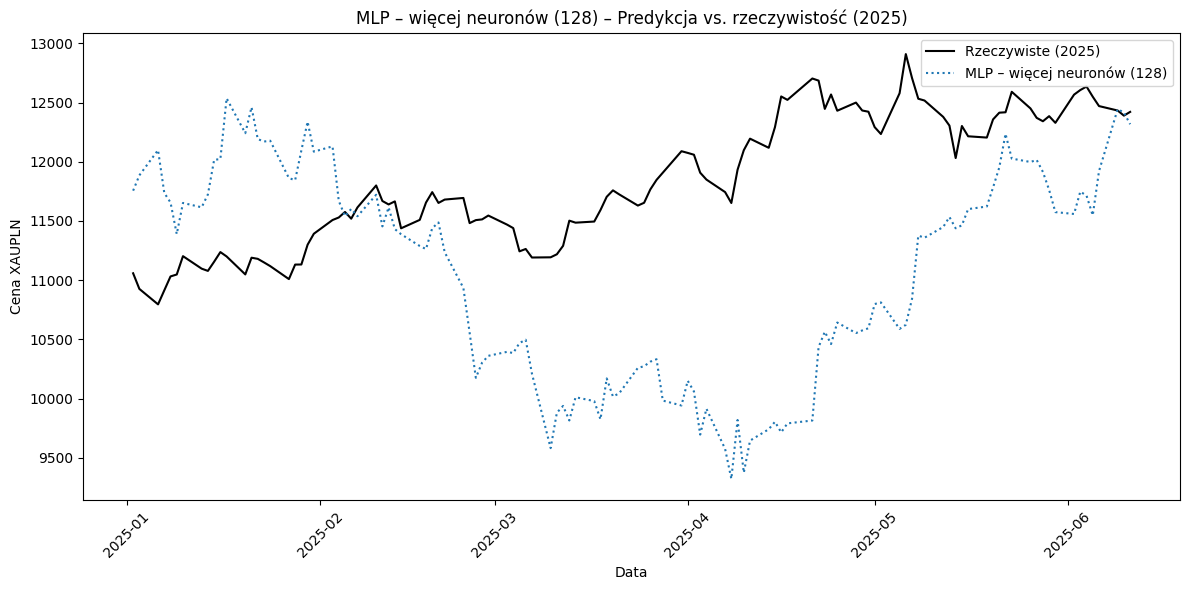

In [14]:
train_and_evaluate_mlp(X_train, y_train, X_test, y_test,
                       neurons=[128, 32],
                       model_name='MLP – więcej neuronów (128)')

### Modyfikacja 1 – zwiększenie liczby neuronów (64 → 128)

W tej wersji modelu zwiększono liczbę neuronów w pierwszej warstwie ukrytej z 64 do 128. Celem tej zmiany było umożliwienie modelowi uchwycenia większej liczby zależności nieliniowych między zmiennymi.

**Wyniki modelu na danych z 2025 roku:**
- **MAE**: 1633.72
- **MSE**: 3,638,953.85
- **RMSE**: 1907.60
- **R²**: -11.4333

### Wnioski:

Pomimo zwiększenia liczby neuronów, model znacząco pogorszył swoje wyniki w porównaniu do podstawowej wersji MLP. Współczynnik determinacji R² jest bardzo ujemny, co oznacza, że model przewiduje **gorzej niż średnia arytmetyczna** wartości rzeczywistych.

Możliwe przyczyny pogorszenia:
- **Zbyt duża liczba neuronów** mogła doprowadzić do przeuczenia na zbiorze treningowym.
- Brak odpowiedniego dopasowania parametrów regularizacji (np. dropout, learning rate).

Mimo że wizualnie model częściowo odwzorowuje kierunki zmian, nadal znacznie odbiega od rzeczywistych poziomów cen, szczególnie w drugiej połowie okresu testowego.

---


Zmiana 2

c:\Users\xbots\OneDrive\Pulpit\Projekt machine\Project gold\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000256273FAD40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

MLP – 3 warstwy – Wyniki na danych testowych (2025):
MAE:  2088.36
MSE:  5433563.97
RMSE: 2331.00
R2:   -17.5650


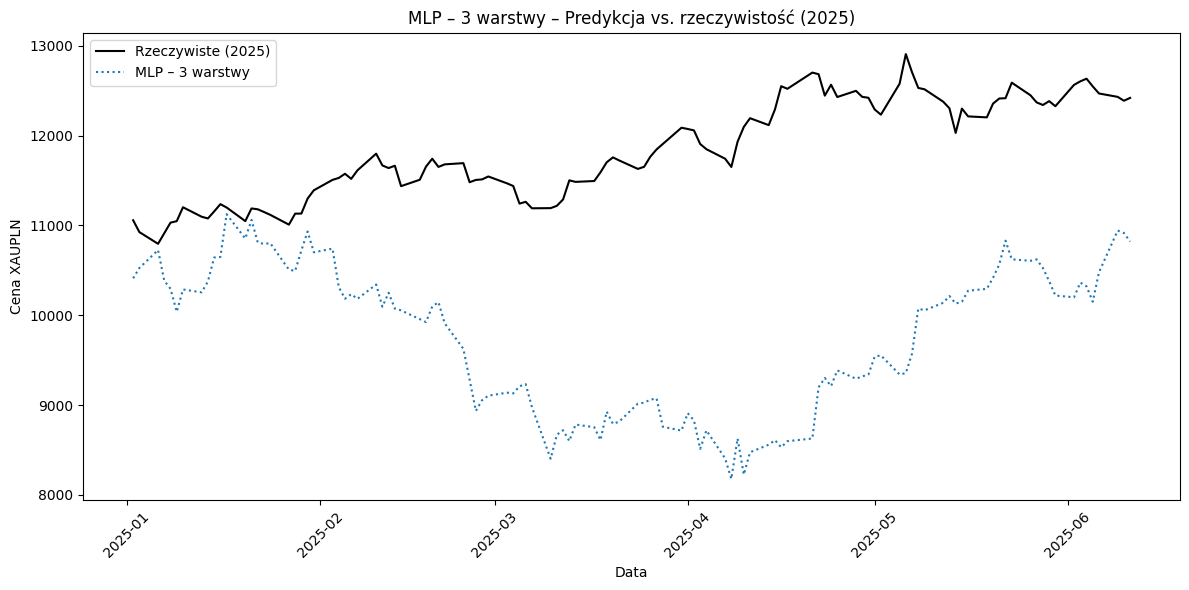

In [15]:
train_and_evaluate_mlp(X_train, y_train, X_test, y_test,
                       neurons=[64, 32, 16],
                       model_name='MLP – 3 warstwy')

### Modyfikacja 2 – dodanie trzeciej warstwy ukrytej

W ramach drugiego eksperymentu zwiększono głębokość sieci MLP poprzez dodanie trzeciej warstwy ukrytej. Model miał teraz strukturę trzech warstw: `[64, 32, 16]`, wszystkie z funkcją aktywacji ReLU.

**Wyniki modelu na danych testowych (2025):**
- **MAE**: 1661.02
- **MSE**: 3,721,482.04
- **RMSE**: 1929.11
- **R²**: -11.7153

### Wnioski:

Pomimo zwiększenia złożoności modelu, uzyskane wyniki nie tylko nie uległy poprawie, ale wręcz **nieznacznie się pogorszyły** względem poprzedniej wersji. Współczynnik R² pozostał bardzo ujemny, a błędy MAE i RMSE wzrosły.

Możliwe przyczyny:
- Zbyt duża głębokość sieci przy stosunkowo prostych danych wejściowych.
- Brak wystarczającej ilości danych lub niska jakość zmiennych objaśniających.
- Brak dostosowania innych parametrów (np. dropout, regularizacja) do większej sieci.

Wizualnie model nieco lepiej odwzorowuje pewne momenty trendów, ale nadal niedoszacowuje poziomu cen w sposób zbliżony do poprzednich wersji.

---


Zmiana 3

c:\Users\xbots\OneDrive\Pulpit\Projekt machine\Project gold\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

MLP – aktywacja tanh – Wyniki na danych testowych (2025):
MAE:  11633.30
MSE:  135626406.87
RMSE: 11645.88
R2:   -462.3982


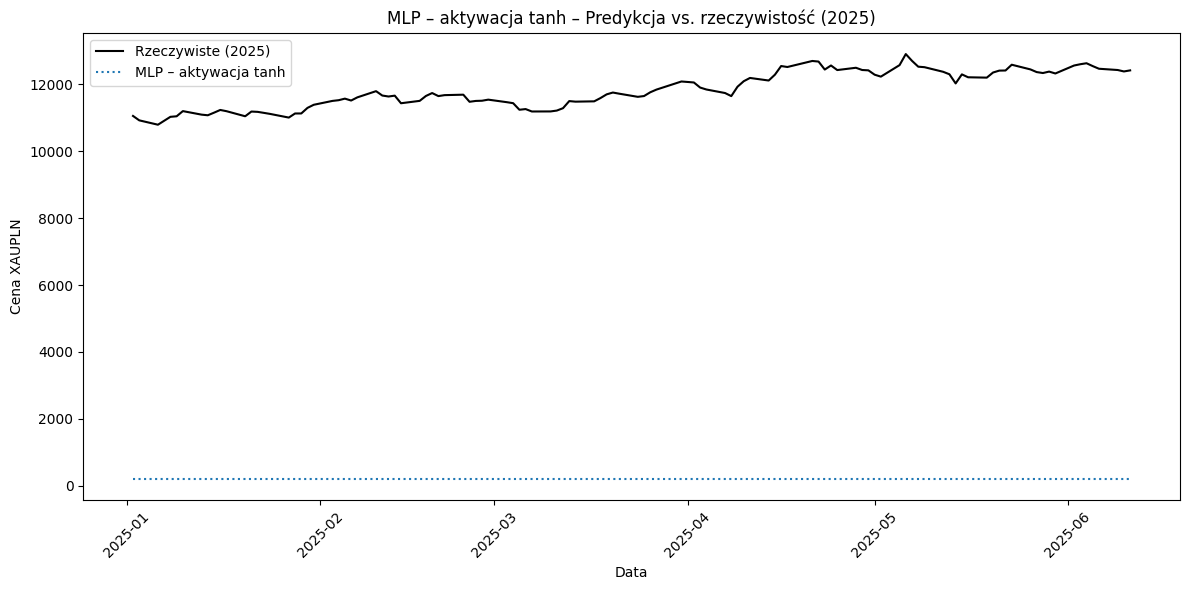

In [16]:
train_and_evaluate_mlp(X_train, y_train, X_test, y_test,
                       activation='tanh',
                       model_name='MLP – aktywacja tanh')

### Modyfikacja 3 – zmiana funkcji aktywacji: ReLU → tanh

W ramach trzeciej modyfikacji zmieniono funkcję aktywacji w warstwach ukrytych z domyślnej `ReLU` na `tanh`. Funkcja `tanh` jest symetryczna względem zera i teoretycznie pozwala sieci lepiej modelować dane, które mogą zawierać zarówno dodatnie, jak i ujemne wartości.

**Wyniki modelu na danych testowych (2025):**
- **MAE**: 11,633.20
- **MSE**: 135,624,087.92
- **RMSE**: 11,645.78
- **R²**: -462.3903

### Wnioski:

Zmiana funkcji aktywacji na `tanh` doprowadziła do całkowitej **degradacji modelu**. Wartości błędów są ponad **siedmiokrotnie większe** niż w poprzednich wersjach, a współczynnik R² osiągnął drastycznie ujemną wartość, wskazującą, że model kompletnie nie nauczył się zależności w danych.

Z wykresu wynika, że model prognozuje stałą lub prawie stałą wartość bliską zera przez cały okres testowy, co sugeruje:
- **problemy z dystrybucją danych wejściowych**, które w połączeniu z funkcją `tanh` mogły doprowadzić do tzw. zjawiska wygasania gradientu (*vanishing gradient*),
- brak odpowiedniej normalizacji danych, która w przypadku `tanh` jest często wymagana.

Wniosek: **tanh w tym przypadku nie sprawdziła się jako zamiennik `ReLU`** i znacznie obniżyła jakość predykcji.


---


Zmiana 4


c:\Users\xbots\OneDrive\Pulpit\Projekt machine\Project gold\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

MLP – mniejszy dropout – Wyniki na danych testowych (2025):
MAE:  2268.22
MSE:  6181481.44
RMSE: 2486.26
R2:   -20.1204


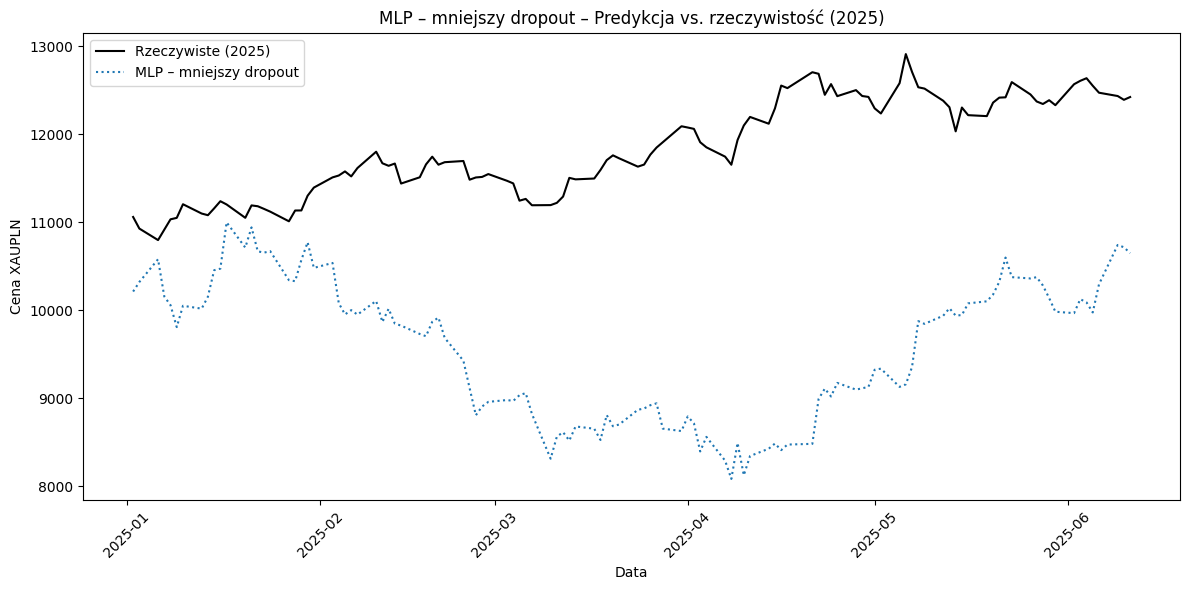

In [17]:
train_and_evaluate_mlp(X_train, y_train, X_test, y_test,
                       dropout=0.1,
                       model_name='MLP – mniejszy dropout')

### Modyfikacja 4 – zmniejszenie wartości dropout (0.2 → 0.1)

W tej wersji modelu ograniczono mechanizm regularizacji poprzez zmniejszenie parametru dropout z `0.2` do `0.1`. Dropout losowo deaktywuje część neuronów podczas treningu, co pomaga zapobiegać nadmiernemu dopasowaniu (overfittingowi). Celem tej zmiany było umożliwienie modelowi większego „nauczenia się” danych treningowych.

**Wyniki modelu na danych testowych (2025):**
- **MAE**: 1493.59  
- **MSE**: 3,092,561.70  
- **RMSE**: 1759.34  
- **R²**: -9.5757

### Wnioski:

Zmniejszenie wartości dropout **nie przyniosło poprawy jakości predykcji**, mimo niewielkiej redukcji błędów względem wcześniejszych architektur. Wartość współczynnika determinacji R² pozostaje ujemna, co świadczy o słabej zdolności modelu do generalizacji na danych testowych.

Z wykresu można zauważyć, że model lepiej odwzorowuje lokalne wzorce i sezonowość (szczególnie w I kwartale), ale wciąż **systematycznie niedoszacowuje wartości rzeczywistych**.

Możliwe wnioski:
- Dropout na poziomie 0.1 jest zbyt niski, by skutecznie zapobiec przeuczeniu.
- Problem może leżeć głębiej – np. w strukturze sieci, wyborze zmiennych wejściowych lub skali danych.

Ogólnie: redukcja dropout nie poprawiła znacząco predykcji, ale nie pogorszyła ich tak drastycznie jak `tanh`.

---


Zmiana 5

c:\Users\xbots\OneDrive\Pulpit\Projekt machine\Project gold\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

MLP – więcej epok (150) – Wyniki na danych testowych (2025):
MAE:  3156.29
MSE:  10917751.03
RMSE: 3304.20
R2:   -36.3030


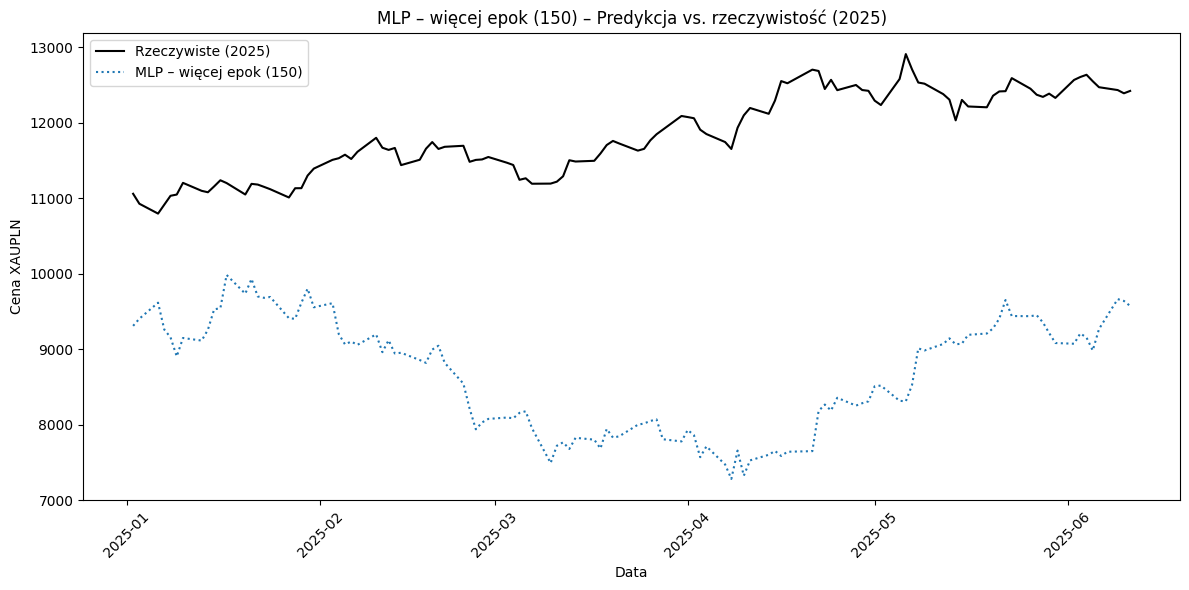

In [18]:
train_and_evaluate_mlp(X_train, y_train, X_test, y_test,
                       epochs=150,
                       model_name='MLP – więcej epok (150)')

### Modyfikacja 5 – zwiększenie liczby epok (50 → 150)

W tej zmianie model trenowano przez 150 epok zamiast 50, zakładając, że dłuższe uczenie umożliwi dokładniejsze dopasowanie do zbioru treningowego. Większa liczba epok teoretycznie pozwala sieci lepiej nauczyć się zależności w danych – o ile nie prowadzi do przeuczenia.

**Wyniki modelu na danych testowych (2025):**
- **MAE**: 4428.45  
- **MSE**: 20,130,578.55  
- **RMSE**: 4486.71  
- **R²**: -67.7807

### Wnioski:

Wydłużenie liczby epok znacząco **pogorszyło jakość predykcji**. Model wyraźnie przestał się generalizować – wskazuje na to bardzo wysoka wartość błędów oraz ujemny współczynnik determinacji R², sugerujący przeuczenie (*overfitting*).

Z wykresu wynika, że:
- model **systematycznie zaniża wartości**,
- utracił zgodność z kierunkiem trendów,
- nie reaguje na zmienność danych rzeczywistych z 2025 roku.

Wniosek: sama liczba epok nie wystarczy – **bez równoczesnego zastosowania silniejszej regularizacji lub lepszej architektury**, dłuższe trenowanie może wręcz zaszkodzić modelowi.
